# Final Project \(Climate Time Series)
### Group Members :- Dhruv Rana, Ahnaf Hasan
---

### Import

In [59]:
import os
import sklearn
import numpy as np 
import pandas as pd 
 
import matplotlib.pyplot as plt 

from skimage.io import imread
from skimage.transform import resize 
from sklearn import model_selection

from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp
from sklearn import model_selection, linear_model

## Examine Labels

In [2]:
BASE_DIR = "./Cat Vs Dog Dataset/"

TRAIN_DIR = BASE_DIR + "train/"
TEST_DIR = BASE_DIR + "test1/"

train_images_filename = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images_filename = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [3]:
print(train_images_filename[0:10])

['./Cat Vs Dog Dataset/train/cat.0.jpg', './Cat Vs Dog Dataset/train/cat.1.jpg', './Cat Vs Dog Dataset/train/cat.10.jpg', './Cat Vs Dog Dataset/train/cat.100.jpg', './Cat Vs Dog Dataset/train/cat.1000.jpg', './Cat Vs Dog Dataset/train/cat.10000.jpg', './Cat Vs Dog Dataset/train/cat.10001.jpg', './Cat Vs Dog Dataset/train/cat.10002.jpg', './Cat Vs Dog Dataset/train/cat.10003.jpg', './Cat Vs Dog Dataset/train/cat.10004.jpg']


In [4]:
print(test_images_filename[0:10])

['./Cat Vs Dog Dataset/test1/1.jpg', './Cat Vs Dog Dataset/test1/10.jpg', './Cat Vs Dog Dataset/test1/100.jpg', './Cat Vs Dog Dataset/test1/1000.jpg', './Cat Vs Dog Dataset/test1/10000.jpg', './Cat Vs Dog Dataset/test1/10001.jpg', './Cat Vs Dog Dataset/test1/10002.jpg', './Cat Vs Dog Dataset/test1/10003.jpg', './Cat Vs Dog Dataset/test1/10004.jpg', './Cat Vs Dog Dataset/test1/10005.jpg']


It seems that the given test dataset is not labeled. Thus we will only work with the given training folder. We will split the training data itself in to training and testing.

## Load Images

In [5]:
Dataset_images_filename = train_images_filename

Image_Height = 100
Image_Width = 100
Image_Channels = 3

classes = {0 : "Cat" , 1 : "Dog" }

In [6]:
def prep_dataset(filename,Height,Width,Ch):
    X = np.ndarray((len(filename),Height*Width*Ch)) # Sample No. , Image
    y = np.zeros((len(filename))) # Sample Label

    for i,image_name in enumerate(filename):

        X[i,:] = resize(imread(image_name),(Height,Width),anti_aliasing=True).flatten()

        if image_name.split('/')[-1].split('.')[0] == 'dog':
            y[i] = 1
        elif image_name.split('/')[-1].split('.')[0] == 'cat':
            y[i] = 0
        else : # for test data
            y[i] = image_name.split('/')[-1].split('.')[0]
    
    return X,y

In [7]:
dataset = prep_dataset(Dataset_images_filename,Image_Height,Image_Width,Image_Channels)

## Examine Data

In [8]:
print("The Dataset has {0} Images".format(len(dataset[0])))

The Dataset has 25000 Images


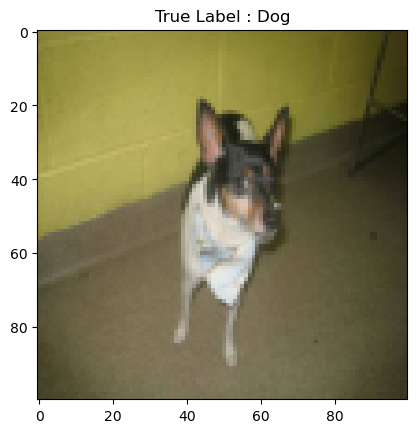

In [9]:
X,y = dataset

def show_image(X,y,idx,classes):
    image = X[idx].reshape((Image_Height, Image_Width, Image_Channels))
    plt.imshow(image)
    plt.title("True Label : {}".format(classes[y[idx]]))
    plt.show()

show_image(X,y,12507,classes)

The length of dataset is 25000. Thus we have 25000 samples and each sample(Image) is 100x100x3, each image has 30000 features.

### Split Data

In [10]:
X_train, X_test , y_train,y_test = model_selection.train_test_split(X,y,train_size=0.7,test_size=0.3,shuffle=True)

## Pre-Processing

Due to the large number of features, it will be really hard to fit the data using any model and may even lead to some ovefitting issues due to num of features beign larger than number of samples. Thus we will use the method we learned in class for dimensonlity reduction : Principle Component Analysis (PCA)

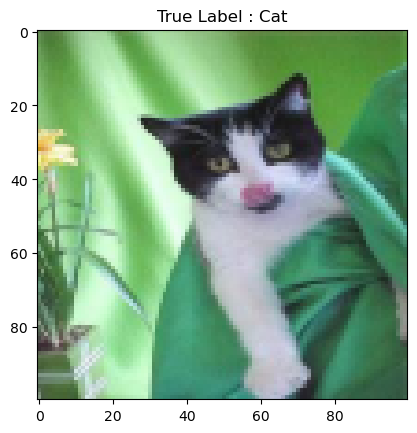

In [11]:
show_image(X_train,y_train,12507,classes)

### Center and Scale the Data

It is a neccessary step to center the data as the PCA methods assumes a mean of 0, and the unit variance of 1 is not required but prefered.

In [12]:
mean_and_std_datascaler = sklpp.StandardScaler(with_mean=True,with_std=True)
centered_data = mean_and_std_datascaler.fit_transform(X_train) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


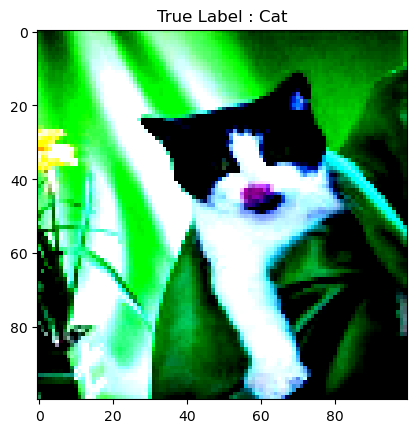

In [13]:
show_image(centered_data,y_train,12507,classes)

### Reduce Dimensons

At first lets observe the data in R<sup>3</sup> based on the label, to see the sparsity of the data

In [40]:
data_pca_3 = skldecomp.PCA(n_components=3)
data_features_3 = data_pca_3.fit_transform(centered_data)

PCA_df = pd.DataFrame(data_features_3,columns=["PC1","PC2","PC3"])
PCA_df["Label"] = y_train

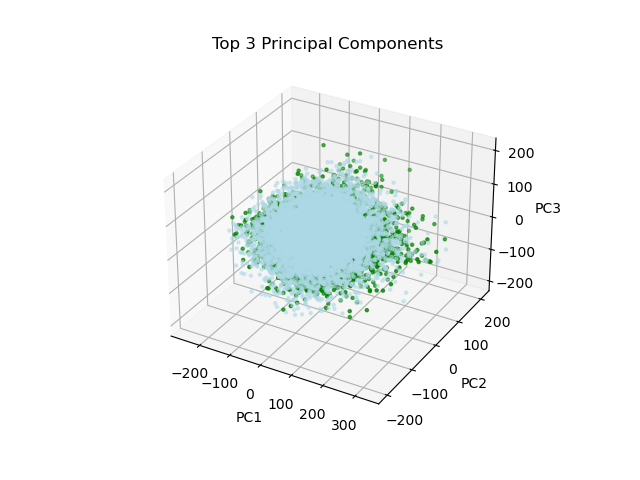

In [58]:
%matplotlib widget
pc1_cat_points = PCA_df[PCA_df["Label"] == 0]["PC1"]
pc2_cat_points = PCA_df[PCA_df["Label"] == 0]["PC2"]
pc3_cat_points = PCA_df[PCA_df["Label"] == 0]["PC3"]

pc1_dog_points = PCA_df[PCA_df["Label"] == 1]["PC1"]
pc2_dog_points = PCA_df[PCA_df["Label"] == 1]["PC2"]
pc3_dog_points = PCA_df[PCA_df["Label"] == 1]["PC3"]

fig = plt.figure()
axs = fig.add_subplot(111,projection='3d')
axs.scatter(pc1_cat_points,pc2_cat_points,pc3_cat_points,c="lightblue",marker=".",alpha=0.5)
axs.scatter(pc1_dog_points,pc2_dog_points,pc3_dog_points,c="green",marker=".")
axs.set_xlabel("PC1")
axs.set_ylabel("PC2")
axs.set_zlabel("PC3")
axs.set_title("Top 3 Principal Components")
plt.show()

We, observe that the data points belonging to cats surrond the data points that belong to dogs. Also, it can bessen that the data points of same class are grouped togeter and have a cluster. 

Instead of 3 components, we want to find k compnenets that capture 90% of the energy of the data

In [30]:
%matplotlib inline
data_pca = skldecomp.PCA(n_components=0.90, svd_solver='full')
data_features = data_pca.fit_transform(centered_data)
print(f"The K that capture energy greater than or equal to 0.90 is : {data_pca.n_components_}")

The K that capture energy greater than or equal to 0.90 is : 243


## Models

For the first model we opted to use logistic regression classifier, beacuse we learned in class that unlike LDA, QDA it does not make any assumption about the data distribution

#### <i>Logistic Regression

In [ ]:
Logisctic_Regression = linear_model.LogisticRegression

## Bibliography

1. Datset : https://www.kaggle.com/c/dogs-vs-cats
2. Logistic Regression Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
3. SVM Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
4. Cross-Validation : https://scikit-learn.org/stable/modules/cross_validation.html